In [68]:
# !pip install simpy
import simpy
print('simpy version: ',simpy.__version__)
import numpy as np
print('numpy version: ',np.__version__)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

simpy version:  3.0.11
numpy version:  1.17.4


# Setup Simpy environment
## Setting simulation to run for 5 days initially

In [18]:
# env = simpy.Environment()
# env

## Define warehouse run event
### Takes order cutoff inventory level as an input-1
### Takes order target inventory level as an input-2

In [52]:
def warehouse_run(env,order_cutoff, order_target):
    global inventory_level,profit,units_ordered
    
    inventory_level = order_target
    profit = 0.0
    units_ordered = 0
    
    #we need an infinite loop
    while True:
        customer_arrival = generate_customer_arrival()
        yield env.timeout(customer_arrival) #wait for the time interval for customer arrival
        profit -= inventory_level*2*customer_arrival
        
        demand = generate_customer_demand()
        #branch-1 : if demand is smaller than inventory, then we can sell complete amount
        if demand < inventory_level:
            profit +=100*demand
            inventory_level -= demand
            print('on {:.2f} day we sold {} and remaining inventory {}'.format(env.now,demand,inventory_level))
        #branch-2: if demand is more than inventory, then sell whatever portion of demand we can satisfy
        else:
            profit += 100*inventory_level
            inventory_level = 0
            print('on {:.2f} day we sold {} (out of stock)'.format(env.now,inventory_level))
    
        if inventory_level < order_cutoff and units_ordered == 0:
            #our inventory levels are below organization's policy level and there are no new orders placed, 
            #in such scenario we need to place an order
            env.process(handle_order(env,order_target))


#process generators
def generate_customer_arrival():
    return np.random.exponential(1.0/5)

#process generators
def generate_customer_demand():
    return np.random.randint(1,5)

def handle_order(env,order_target):
    global inventory_level,profit,units_ordered
    
    
    units_ordered = order_target -inventory_level
    print('on {:.2f} day we placed an order for {}'.format(env.now,units_ordered))
    profit -= 50*units_ordered
    yield env.timeout(2.0)
    inventory_level += units_ordered
    print('on {:.2f} day we received an order for {} and inventory level = {}'.format(env.now,units_ordered,inventory_level))
    units_ordered = 0


## Attaching process generators to Simpy environment - This step enables to run simulations later

In [80]:
def observe(env,observation_time,inventory_level_list):
    global inventory_level
    
    while True:
        observation_time.append(env.now)
        inventory_level_list.append(inventory_level)
        yield env.timeout(0.1) #we will get 10 observations per day

        
observation_time = []
inventory_level_list = []

env = simpy.Environment()
env.process(warehouse_run(env,10,30))
env.process(observe(env,observation_time,inventory_level_list))
env

<Process(warehouse_run) object at 0x269050040f0>

<Process(observe) object at 0x26905004160>

## Simulating for 5 days
### Before starting simulation, always set random seed to a specific number for reproducing the same results

In [62]:
np.random.seed(0)
env.run(until=5.0)

on 0.16 day we sold 2 and remaining inventory 28
on 0.53 day we sold 4 and remaining inventory 24
on 0.69 day we sold 2 and remaining inventory 22
on 0.88 day we sold 3 and remaining inventory 19
on 1.00 day we sold 3 and remaining inventory 16
on 1.01 day we sold 1 and remaining inventory 15
on 1.11 day we sold 3 and remaining inventory 12
on 1.44 day we sold 3 and remaining inventory 9
on 1.44 day we placed an order for 21
on 1.61 day we sold 2 and remaining inventory 7
on 1.97 day we sold 1 and remaining inventory 6
on 1.99 day we sold 4 and remaining inventory 2
on 2.08 day we sold 0 (out of stock)
on 2.38 day we sold 0 (out of stock)
on 2.79 day we sold 0 (out of stock)
on 3.11 day we sold 0 (out of stock)
on 3.26 day we sold 0 (out of stock)
on 3.28 day we sold 0 (out of stock)
on 3.44 day we received an order for 21 and inventory level = 21
on 3.46 day we sold 2 and remaining inventory 19
on 4.04 day we sold 4 and remaining inventory 15
on 4.06 day we sold 4 and remaining invent

## Visualization - Where simulations come to life

,Time,Inventory_Level
0,0,30
1,0.1,30
2,0.2,28
3,0.3,28
4,0.4,28
5,0.5,28
6,0.6,24
7,0.7,22
8,0.8,22
9,0.9,19


<Figure size 432x288 with 0 Axes>

Text(0.5, 0, 'Simulation Time (days)')

Text(0, 0.5, 'Inventory level (units)')

profit = $2,689.70


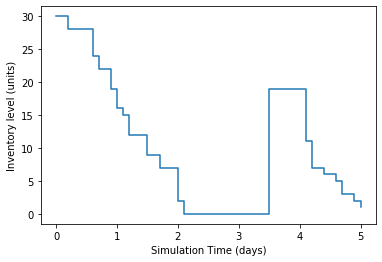

In [69]:
import matplotlib.pyplot as plt
import pandas as pd

inventory_DF = pd.DataFrame({
                            'Time':observation_time,
                            'Inventory_Level':inventory_level_list
})

inventory_DF.style

plt.figure()
plt.step(observation_time,inventory_level_list,where='post')
plt.xlabel('Simulation Time (days)')
plt.ylabel('Inventory level (units)')

print('profit = ${:0,.2f}'.format(profit))

In [88]:
# inventory_DF.plot()

def run_simulation(days,cutoff,target):
    observation_time = []
    inventory_level_list = []
    env = simpy.Environment()
    env.process(warehouse_run(env,cutoff,target))
    env.process(observe(env,observation_time,inventory_level_list))
    env.run(until=days)
    inventory_DF = pd.DataFrame({
                            'Time':observation_time,
                            'Inventory_Level':inventory_level_list
    })
    return inventory_DF

# Simulate for 1 year with different cutoff and target levels

on 0.05 day we sold 4 and remaining inventory 96
on 0.45 day we sold 1 and remaining inventory 95
on 0.61 day we sold 1 and remaining inventory 94
on 0.85 day we sold 4 and remaining inventory 90
on 1.14 day we sold 2 and remaining inventory 88
on 1.24 day we sold 4 and remaining inventory 84
on 1.54 day we sold 3 and remaining inventory 81
on 1.92 day we sold 2 and remaining inventory 79
on 2.01 day we sold 2 and remaining inventory 77
on 2.10 day we sold 1 and remaining inventory 76
on 2.18 day we sold 1 and remaining inventory 75
on 2.19 day we sold 3 and remaining inventory 72
on 2.20 day we sold 3 and remaining inventory 69
on 2.38 day we sold 2 and remaining inventory 67
on 2.43 day we sold 2 and remaining inventory 65
on 2.45 day we sold 1 and remaining inventory 64
on 2.82 day we sold 4 and remaining inventory 60
on 2.97 day we sold 2 and remaining inventory 58
on 3.00 day we sold 4 and remaining inventory 54
on 3.03 day we sold 2 and remaining inventory 52
on 3.42 day we sold 

on 345.07 day we sold 4 and remaining inventory 60
on 345.18 day we sold 1 and remaining inventory 59
on 345.26 day we sold 3 and remaining inventory 56
on 345.55 day we sold 4 and remaining inventory 52
on 346.67 day we sold 4 and remaining inventory 48
on 346.67 day we placed an order for 52
on 347.01 day we sold 3 and remaining inventory 45
on 347.16 day we sold 1 and remaining inventory 44
on 347.29 day we sold 1 and remaining inventory 43
on 347.61 day we sold 1 and remaining inventory 42
on 347.72 day we sold 2 and remaining inventory 40
on 347.95 day we sold 2 and remaining inventory 38
on 348.23 day we sold 1 and remaining inventory 37
on 348.46 day we sold 4 and remaining inventory 33
on 348.67 day we received an order for 52 and inventory level = 85
on 348.67 day we sold 2 and remaining inventory 83
on 348.94 day we sold 1 and remaining inventory 82
on 349.07 day we sold 4 and remaining inventory 78
on 349.23 day we sold 3 and remaining inventory 75
on 349.42 day we sold 4 an

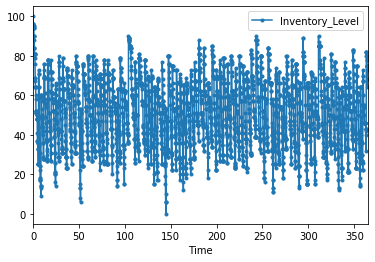

In [89]:
inventory_DF = run_simulation(365,50,100)
inventory_DF.plot(x='Time', y='Inventory_Level',style='.-')